# Data Collection and Processing

In this part we focus on obtaining and preparing the required stock data for subsequent analysis. The main source include: **Wikipedia** for retrieving a list of stocks, **Yahoo Finance** for financial and historical stock data, and additional processing to calculate correlations between stocks based on daily log returns.

## 1. Dependencies

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
import wikipedia as wp
import numpy as np
import seaborn as sns
import dcor
import networkx as nx

## 2. Import S&P 100 List and Information

**List of S&P 100 Companies**

* We scraped the S&P 100 stocks table from Wikipedia to obtain a list of stock tickers and their respective company names.
* The data was cleaned to address specific issues, such as handling dual-class tickers like GOOG and GOOGL and renaming BRK.B to BRK-B for compatibility with data sources.
* Finally we saved the information in a CSV file `stocks.csv`.

In [34]:
url=wp.page("S&P 100").html().encode("UTF-8")
stocks=pd.read_html(url)[2].set_index("Symbol")
stocks=stocks.drop("GOOG")
stocks.loc["GOOGL","Name"]="Alphabet"
stocks=stocks.rename(index={"BRK.B":"BRK-B"})
stocks.head()

,Name,Sector
Symbol,,
AAPL,Apple Inc.,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe Inc.,Information Technology


In [35]:
stocks.to_csv("../data/stocks.csv")

**Fundamental Data of companies**

* We use **Yahoo Finance API** to get fundamental financial data for each stock. The data include: Market Capitalization (`marketCap`), Beta (`beta`), 52-week change (`52WeekChange`), Average Volume (`averageVolume`) and Profit Margins (`profitMargins`).
* We fill the missing values with zero for consistency.

In [36]:
fundamentals=[yf.Ticker(stock).info for stock in stocks.index]

fundamentals=pd.DataFrame(fundamentals).set_index("symbol")
fundamentals.index = fundamentals.index.rename("Symbol")
fundamentals= fundamentals[["marketCap", "beta", "52WeekChange", "averageVolume", "profitMargins"]].fillna(0)
fundamentals.head()

,marketCap,beta,52WeekChange,averageVolume,profitMargins
Symbol,,,,,
AAPL,3785298542592,1.240,0.359132,43444376,0.23971
ABBV,314020757504,0.613,0.107441,6162744,0.09223
ABT,196184768512,0.722,0.032779,5010134,0.13992
ACN,220037611520,1.245,0.041045,2420925,0.11194
ADBE,195748134912,1.299,-0.222302,3436926,0.25588


**Log Daily Return**

* We fetch the historical price data for the past 5 years for each stock.
* From the price data, we calculate the daily log return and standardized for use in correlation analysis.

In [37]:
values=[yf.Ticker(stock).history(period="5y",actions=False) for stock in stocks.index]

for idx, stock_values in enumerate (values):
    stock_values["NormClose"]=(stock_values["Close"].mean())/stock_values["Close"].std()
    
    stock_values["DailyLogReturn"]=np.log(1+stock_values["Close"].pct_change())
    stock_values["DailyLogReturn"] /= stock_values["DailyLogReturn"].std()
    stock_values.drop(columns=["Open","High","Low","Close","NormClose","Volume"],inplace=True)
    
values=pd.concat(values, keys=stocks.index).dropna()
values.head(n=5)

DailyLogReturn
Symbol Date                                     
AAPL   2020-01-03 00:00:00-05:00       -0.489956
       2020-01-06 00:00:00-05:00        0.398013
       2020-01-07 00:00:00-05:00       -0.236393
       2020-01-08 00:00:00-05:00        0.800302
       2020-01-09 00:00:00-05:00        1.054072

## 3. EDA

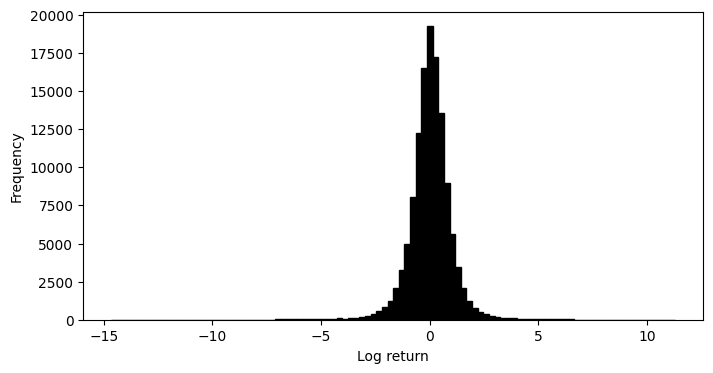

In [67]:
plt.figure(figsize=(8,4))

column="DailyLogReturn"
plt.hist(values[column],bins=100,color="black",edgecolor="black")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

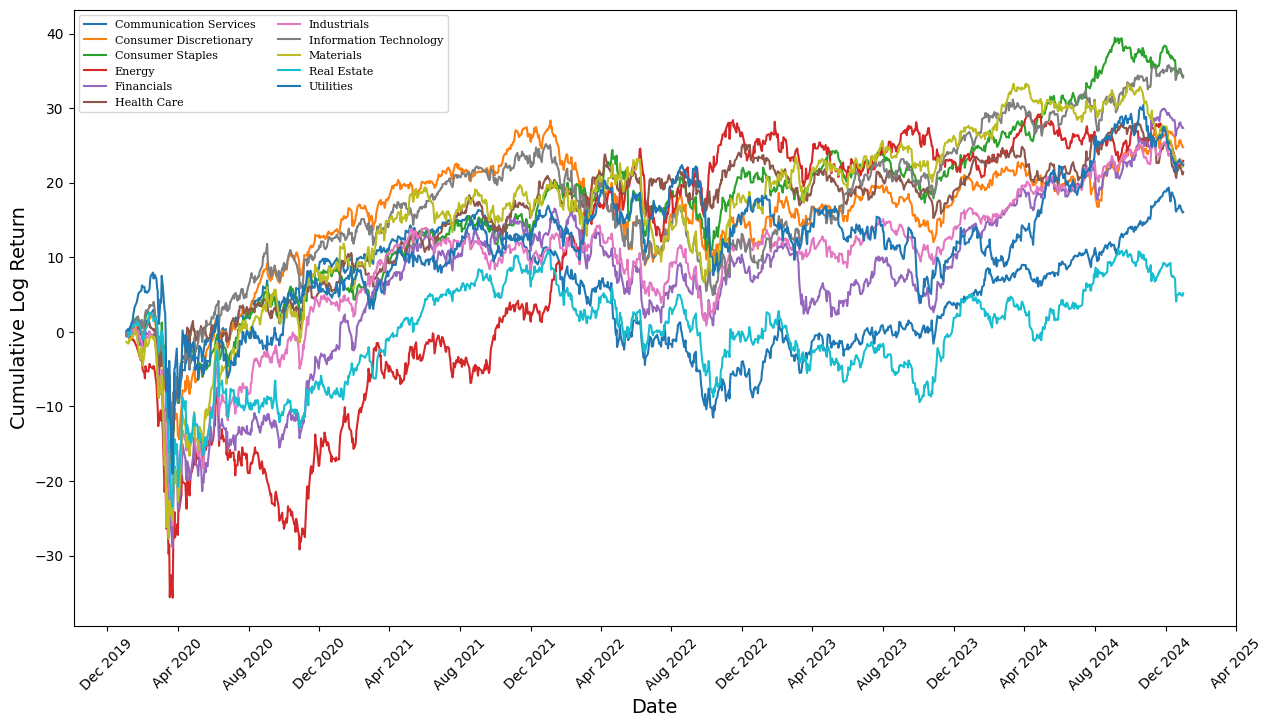

In [68]:
values_eda = values.copy().reset_index()
values_eda["Sector"] = values_eda["Symbol"].map(stocks["Sector"])


sector_values_grouped = (
    values_eda.groupby(["Date", "Sector"])["DailyLogReturn"].mean().unstack()
)

global_min = sector_values_grouped.cumsum().min().min()
global_max = sector_values_grouped.cumsum().max().max()

plt.figure(figsize=(15, 8))
for sector in sector_values_grouped.columns:
    plt.plot(
        sector_values_grouped.index,
        sector_values_grouped[sector].cumsum(),
        label=sector,
    )
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Log Return", fontsize=14)
plt.legend(ncol=2, loc="best", prop={"size": 8, "family": "serif"})
plt.gca().tick_params(axis="x", rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.show()

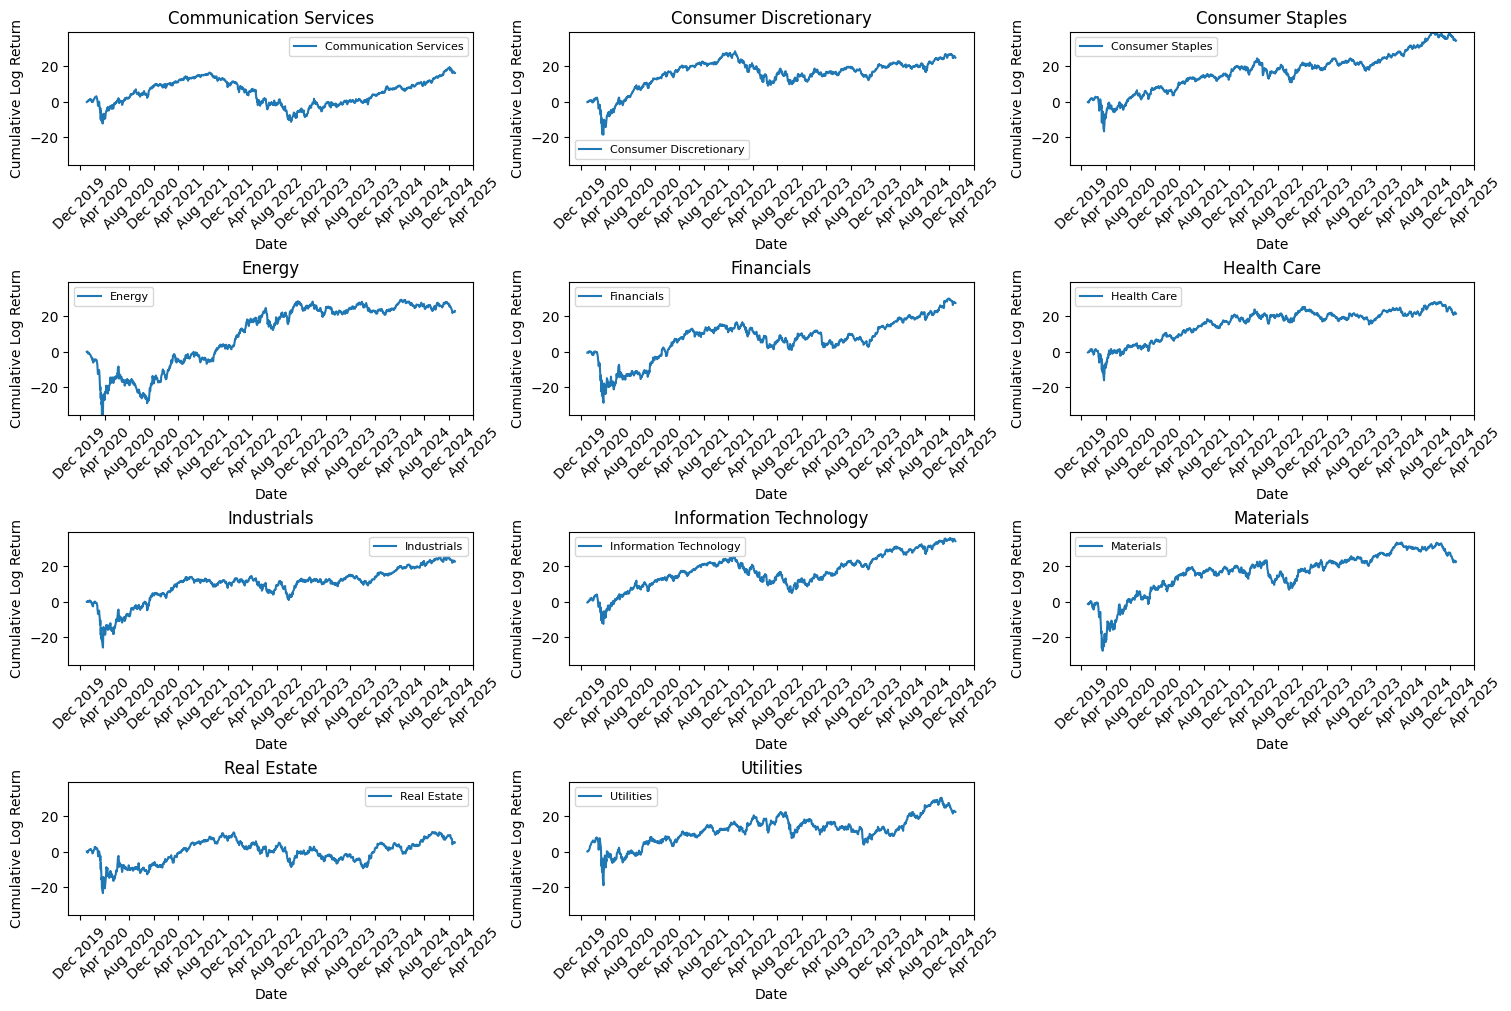

In [69]:
n_cols = 3
n_rows = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

for idx, sector in enumerate(sector_values_grouped.columns):
    ax = axes[idx]
    ax.plot(
        sector_values_grouped.index,
        sector_values_grouped[sector].cumsum(),
        label=sector,
    )
    ax.set_title(sector)
    ax.set_xlabel("Date")
    ax.tick_params(axis="x", rotation=45)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.set_ylabel("Cumulative Log Return")
    ax.legend(loc="best", fontsize=8)
    
    ax.set_ylim(global_min, global_max)

for idx in range(len(sector_values_grouped.columns), len(axes)):
    fig.delaxes(axes[idx])
plt.show()

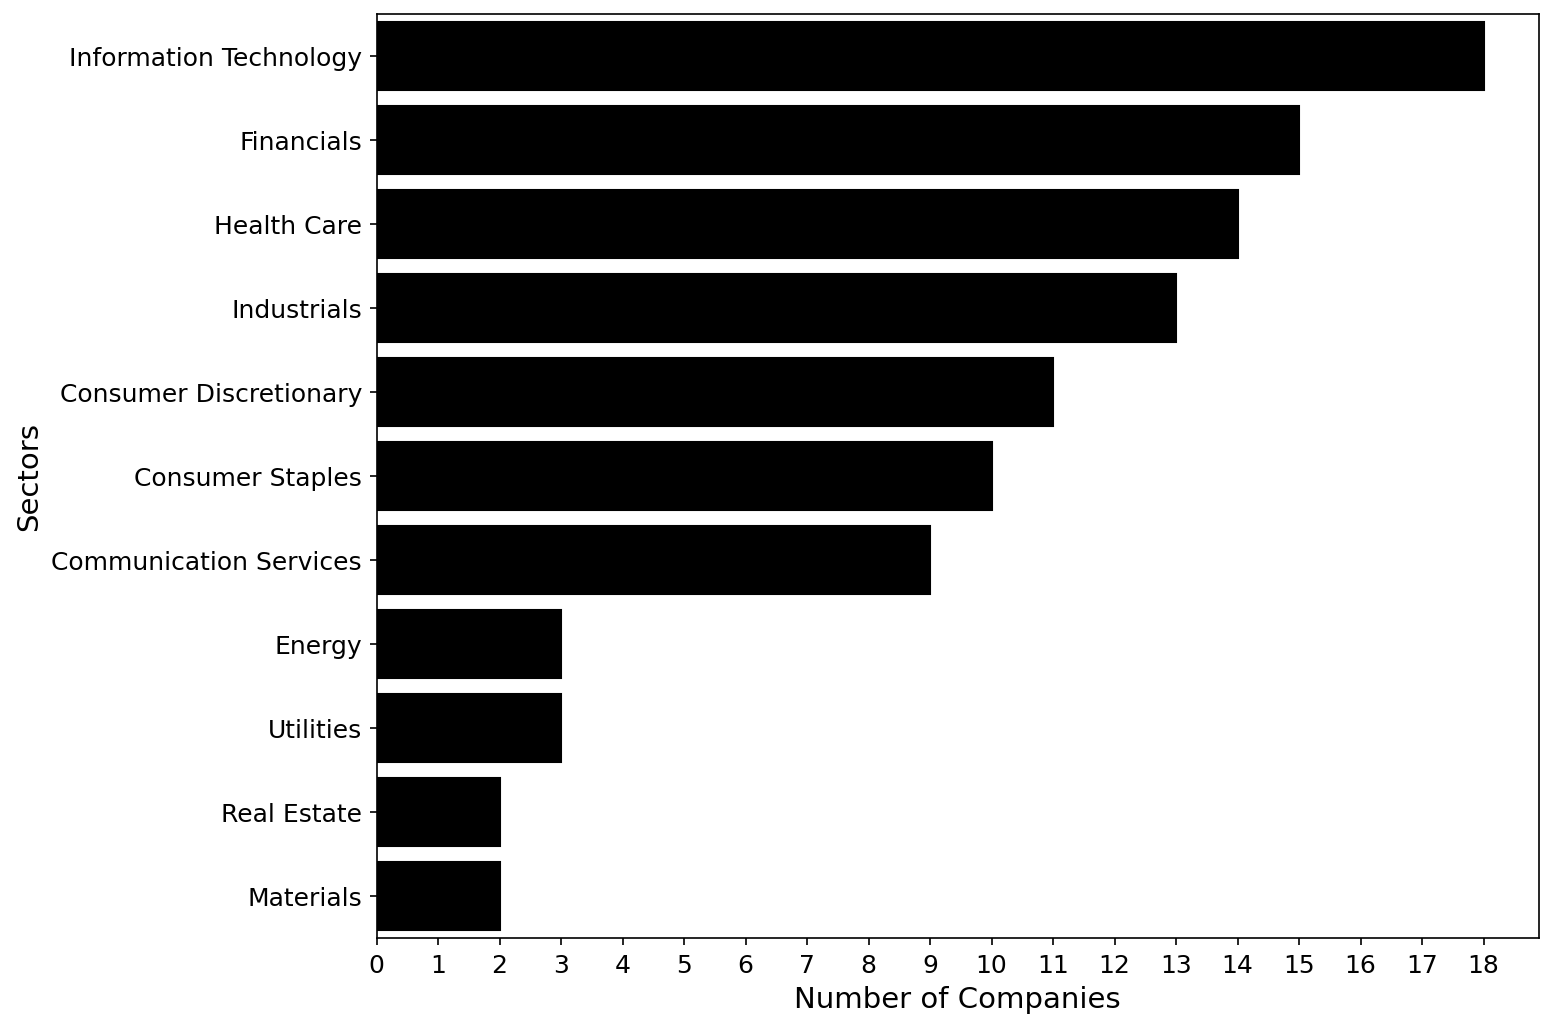

In [72]:
company_counts = stocks["Sector"].value_counts().reset_index()
company_counts.columns = ["Sector", "Company Count"]

plt.figure(figsize=(10, 8), dpi=150)
sns.barplot(
    data=company_counts,
    y="Sector",
    x="Company Count",
    color="black",
    edgecolor="black"
)
plt.xlabel("Number of Companies", fontsize=14)
plt.ylabel("Sectors", fontsize=14)

plt.xticks(
    np.arange(0, company_counts["Company Count"].max() + 1, step=1), 
    fontsize=12
)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
fundamentals['marketCap_billion'] = fundamentals['marketCap'] / 1e9  
market_cap_classes = {
    'blue_chip': [],
    'large_cap': [],
    'mid_cap': [],
    'small_cap': []
}

for stock, capital in fundamentals['marketCap_billion'].items():
    if capital < 50:  
        market_cap_classes['small_cap'].append(stock)
    elif 50 <= capital < 100:  
        market_cap_classes['mid_cap'].append(stock)
    elif 100 <= capital < 1000:  
        market_cap_classes['large_cap'].append(stock)
    elif capital >= 1000:  
        market_cap_classes['blue_chip'].append(stock)

market_cap_df = pd.DataFrame({
    'position': ['blue_chip', 'large_cap', 'mid_cap', 'small_cap'],
    'number_of_company': [
        len(market_cap_classes['blue_chip']),
        len(market_cap_classes['large_cap']),
        len(market_cap_classes['mid_cap']),
        len(market_cap_classes['small_cap'])
    ]
})

print(market_cap_df)

    position  number_of_company
0  blue_chip                  8
1  large_cap                 67
2    mid_cap                 20
3  small_cap                  5


In [74]:
print({category: companies for category, companies in market_cap_classes.items()})

{'blue_chip': ['AAPL', 'AMZN', 'AVGO', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA'], 'large_cap': ['ABBV', 'ABT', 'ACN', 'ADBE', 'AMD', 'AMGN', 'AXP', 'BA', 'BAC', 'BKNG', 'BLK', 'BMY', 'BRK-B', 'C', 'CAT', 'CMCSA', 'COP', 'COST', 'CRM', 'CSCO', 'CVX', 'DE', 'DHR', 'DIS', 'GE', 'GILD', 'GS', 'HD', 'HON', 'IBM', 'INTU', 'JNJ', 'JPM', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MRK', 'MS', 'NEE', 'NFLX', 'NKE', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'QCOM', 'RTX', 'SBUX', 'SCHW', 'T', 'TMO', 'TMUS', 'TXN', 'UNH', 'UNP', 'UPS', 'V', 'VZ', 'WFC', 'WMT', 'XOM'], 'mid_cap': ['AMT', 'BK', 'CL', 'COF', 'CVS', 'DUK', 'EMR', 'FDX', 'GD', 'GM', 'INTC', 'MDLZ', 'MET', 'MMM', 'MO', 'PYPL', 'SO', 'SPG', 'TGT', 'USB'], 'small_cap': ['AIG', 'CHTR', 'DOW', 'F', 'KHC']}


## 4. Correlation Analysis

In this case, we decided to focus in the correlation distance instead of the correlation of Pearson. This based on the paper: (Ugwu, S.; Miasnikof, P.; Lawryshyn, Y. Distance Correlation Market Graph: The Case of S&P500 Stocks. *Mathematics* **2023**, *11*, 3832. https://doi.org/10.3390/math11183832)

Were they suggest that the distance correlation metric get more information about the non-linear relationship between the stock.

**Reset the index from value dataset and get a pivot matrix**

In [ ]:
values=values.reset_index()
DailyReturn=values.pivot(index="Date",columns="Symbol",values="DailyLogReturn").dropna()
DailyReturn.head(n=2)

**Calculate Correlation matrix**

In [ ]:
tickers=DailyReturn.columns
dcor_matrix=pd.DataFrame(index=tickers,columns=tickers,dtype=float)

for i, stock_a in enumerate(tickers):
    for j, stock_b in enumerate(tickers):
        if i<j:
            dcor_value=dcor.distance_correlation(
                DailyReturn[stock_a].values,
                DailyReturn[stock_b].values
            )
            dcor_matrix.loc[stock_a,stock_b]=dcor_value
            dcor_matrix.loc[stock_b,stock_a]=dcor_value

for ticker in tickers:
    dcor_matrix.loc[ticker, ticker]=1.0
    

print (dcor_matrix)

In [13]:
dcor_long=dcor_matrix.reset_index()

dcor_long=dcor_long.melt(
    id_vars="Symbol",
    var_name="stock_b",
    value_name="correlation"
)

dcor_long=dcor_long.dropna()
dcor_long=dcor_long[dcor_long["Symbol"] != dcor_long["stock_b"]]
dcor_long=dcor_long.rename(columns={"Symbol":"stock_a"})

dcor_long.to_csv("../data/correlation.csv",index=False)

**Dissimilarity Matrix**

In [ ]:
dissimilarity_matrix=1-dcor_matrix
for ticker in tickers:
    dissimilarity_matrix.loc[ticker,ticker]=0.0

print(dissimilarity_matrix)

**Aplication of the Minimum Spanning Tree (MST)**

In [ ]:
G = nx.Graph()
for i, stock_a in enumerate(tickers):
    for j, stock_b in enumerate(tickers):
        if i<j:
            weight = dissimilarity_matrix.loc[stock_a,stock_b]
            G.add_edge(stock_a,stock_b,weight=weight)

mst=nx.minimum_spanning_tree(G)

print(list(mst.edges(data=True)))

In [45]:
mst_edges=[{"stock_a":edge[0],"stock_b":edge[1], "weight":edge[2]["weight"]} for edge in mst.edges(data=True)]
mst_df=pd.DataFrame(mst_edges)
mst_df.to_csv("../data/mst_edges.csv",index=False)